In [41]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.nn as nn

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10]  # Display first 10 words


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words
)  # Total number of words


32033

In [5]:
#build the vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i , s in enumerate(chars)}  # char to index
stoi['.'] = 0  # add a special end-of-word token
itos = {i:s for s, i in stoi.items()}  # index to char
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [9]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)


In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [11]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [12]:

C = torch.randn((27, 2))

In [13]:

emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [14]:

W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [15]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [16]:
h

tensor([[ 1.0000,  0.9979, -0.5613,  ...,  1.0000, -1.0000,  0.9999],
        [ 0.9359, -0.9826,  0.9923,  ...,  1.0000, -1.0000,  1.0000],
        [-1.0000,  1.0000,  0.9999,  ...,  1.0000, -0.9997, -0.9983],
        ...,
        [-0.9957,  0.1150, -0.8711,  ...,  1.0000,  0.5520,  0.9988],
        [-0.9985,  0.9239, -0.7126,  ...,  1.0000, -0.2656,  0.9891],
        [-0.9934,  0.9933, -0.1455,  ...,  1.0000,  0.8912, -0.1272]])

In [17]:
h.shape

torch.Size([228146, 100])

In [18]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)


In [19]:
logits = h @ W2 + b2

In [20]:
logits.shape

torch.Size([228146, 27])

In [21]:
counts = logits.exp()

In [22]:
prob = counts / counts.sum(1, keepdim=True)

In [23]:
prob.shape

torch.Size([228146, 27])

In [24]:
prob.sum()

tensor(228145.9844)

In [32]:
loss = -prob[torch.arange(len(Ytr)), Ytr].log().mean()

In [33]:
loss

tensor(17.6183)

In [34]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [35]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [36]:

sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [37]:

for p in parameters:
  p.requires_grad = True

In [38]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [39]:
lri = []
lossi = []
stepi = []

In [42]:

for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

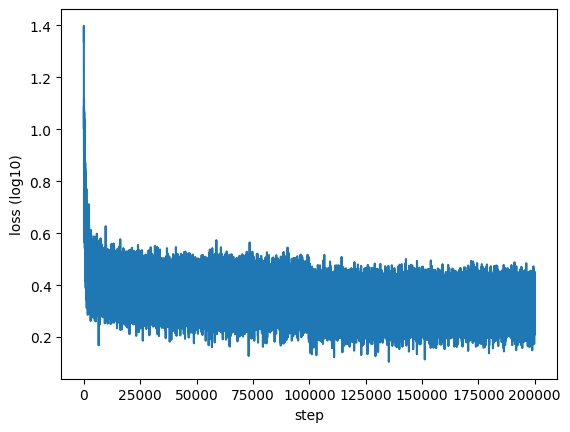

In [ ]:
plt.plot(stepi, lossi)
plt.xlabel('step')
plt.ylabel('loss (log10)')
plt.show()


In [54]:
lri, lossi, stepi = np.array(lri), np.array(lossi), np.array(stepi)

In [44]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1396, grad_fn=<NllLossBackward0>)

In [45]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1795, grad_fn=<NllLossBackward0>)

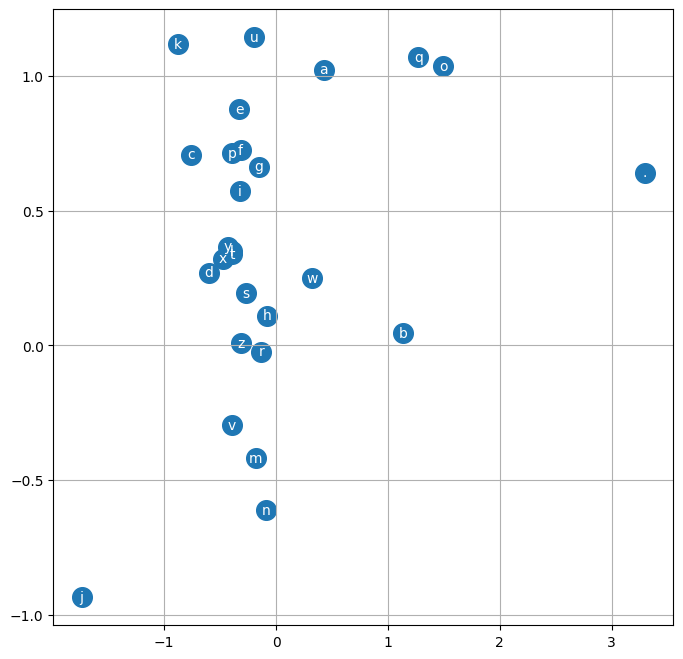

In [46]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [47]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [50]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(30):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahxaan.
hari.
kimlie.
taty.
salaysa.
jazhnen.
delynn.
jareei.
nellara.
chaiir.
kaleigh.
ham.
joce.
quinn.
shoine.
livabi.
wazelo.
dearynn.
jaceenius.
toe.
depi.
abethaley.
frana.
aseidh.
hisya.
naquor.
zerycollia.
caidren.
kalya.
lulo.
